In [1]:
from backtest import do_simulation
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [2]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

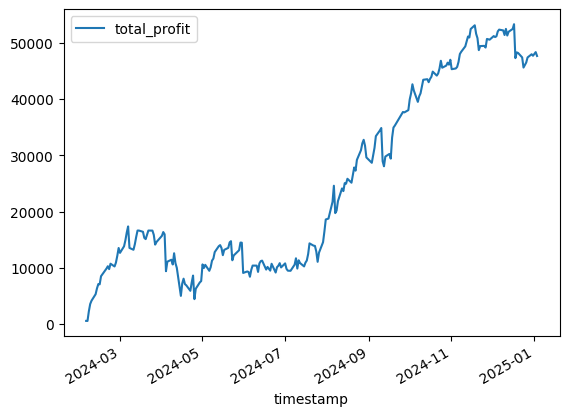

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

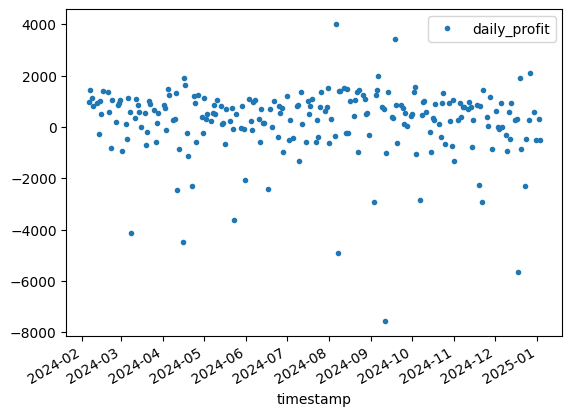

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

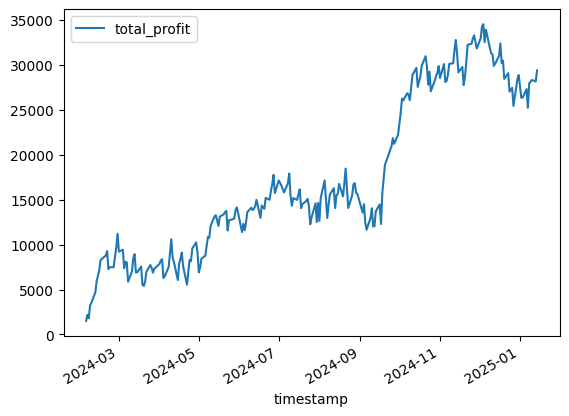

In [ ]:
profit_df, daily_movements = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

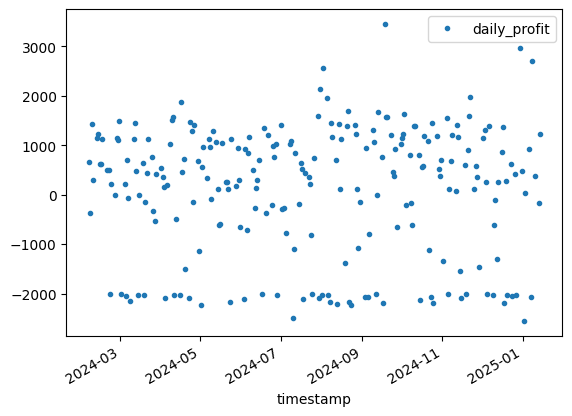

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

Some potential P&L analysis based on daily position movement

In [39]:
EXLUDE_LAST_N = 30

In [10]:
import matplotlib.pyplot as plt

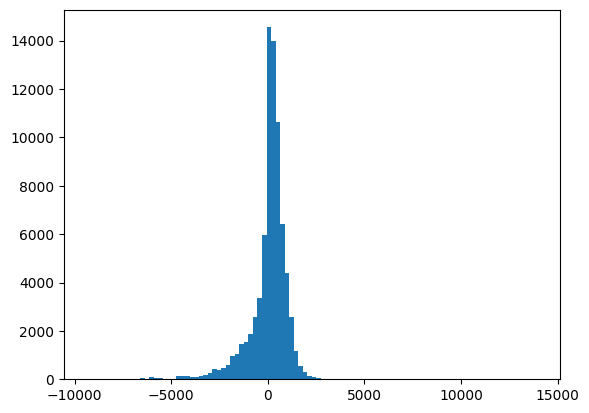

In [46]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

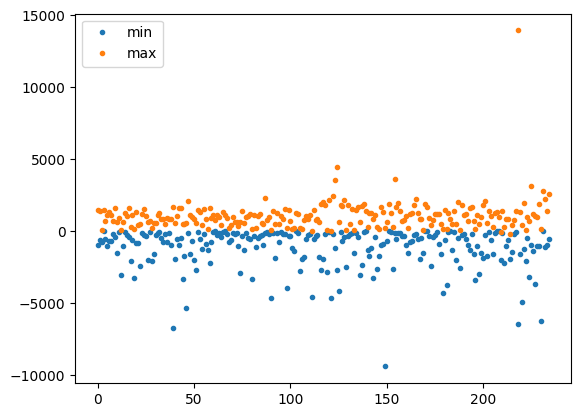

In [47]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [48]:
n_days = daily_min_max_df.shape[0]

In [49]:
profit_categories = [2000, 1750, 1500, 1250, 1000, 750, 500, 250]
loss_categories = [-250, -500, -750, -1000, -1250, -1500, -1750, -2000]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({2000: 0.06808510638297872,
  1750: 0.1276595744680851,
  1500: 0.20425531914893616,
  1250: 0.3404255319148936,
  1000: 0.502127659574468,
  750: 0.6340425531914894,
  500: 0.7787234042553192,
  250: 0.8680851063829788},
 {-250: 0.7191489361702128,
  -500: 0.5872340425531914,
  -750: 0.46808510638297873,
  -1000: 0.39148936170212767,
  -1250: 0.3276595744680851,
  -1500: 0.28936170212765955,
  -1750: 0.23404255319148937,
  -2000: 0.1829787234042553})

In [50]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                int(
                    (daily_movement[:-EXLUDE_LAST_N] >= profit_cat).any()
                    and (daily_movement[:-EXLUDE_LAST_N] <= loss_cat).any()
                )
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,2000,1750,1500,1250,1000,750,500,250
-250,0.038298,0.072340,0.123404,0.187234,0.293617,0.387234,0.502128,0.587234
-500,0.029787,0.051064,0.089362,0.144681,0.212766,0.280851,0.374468,0.455319
-750,0.021277,0.042553,0.068085,0.093617,0.131915,0.174468,0.259574,0.336170
-1000,0.017021,0.038298,0.055319,0.063830,0.093617,0.123404,0.200000,0.268085
-1250,0.008511,0.021277,0.038298,0.042553,0.059574,0.080851,0.153191,0.212766
-1500,0.008511,0.021277,0.034043,0.038298,0.051064,0.072340,0.131915,0.182979
-1750,0.008511,0.021277,0.034043,0.034043,0.038298,0.055319,0.102128,0.144681
-2000,0.008511,0.012766,0.025532,0.025532,0.029787,0.034043,0.068085,0.102128


<Axes: >

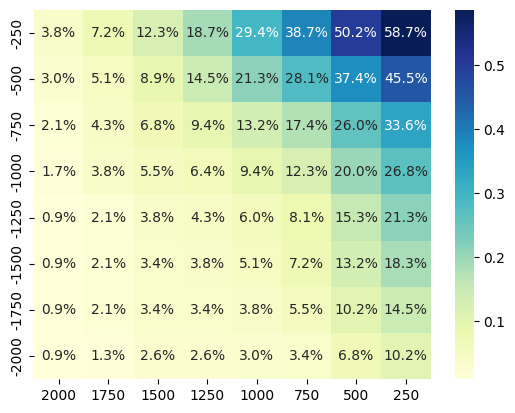

In [51]:
import seaborn as sns

sns.heatmap(profit_loss_matrix, annot=True, fmt=".1%", cmap="YlGnBu")